In [1]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import os
import json
import shutil
from glob import glob

In [2]:
def overlay_heatmap(img,att,cmap=plt.cm.jet):
    gamma = 1.0
    att = cv2.blur(att,(35,35))
    colorized = cmap(np.uint8(att*255))
    alpha = 0.6
    overlaid = np.uint8(img*(1-alpha)+colorized[:,:,2::-1]*255*alpha)
    return overlaid

In [5]:
raw_data = np.load('visualization_result_DINet_final.npy', allow_pickle=True).item()
vis_dir = 'visualization_dinet_final/'
img_dir = '/srv/chenshi/data/mscoco/images/val2014/'
# concept_dict = json.load(open('/srv/chenshi/project/object_fractorization/multi_label_classification/clip_proto_dict.json'))
if not os.path.exists(vis_dir):
    os.mkdir(vis_dir)

In [4]:
id2concept = dict()
for c in concept_dict:
    id2concept[concept_dict[c]['idx']] = c

NameError: name 'concept_dict' is not defined

In [6]:
num_vis = 10
for proto_idx in raw_data:
#     proto_name = id2concept[proto_idx]
    proto_name = str(proto_idx)
    if not os.path.exists(os.path.join(vis_dir, proto_name)):
        os.mkdir(os.path.join(vis_dir, proto_name))
    img_pool = list(raw_data[proto_idx].keys())
    img_pool = np.random.choice(img_pool, min(num_vis, len(img_pool)), replace=False)
    for img_id in img_pool:
        cur_img = cv2.imread(os.path.join(img_dir, img_id+'.jpg'))
        height, width, _ = cur_img.shape
        cur_map = raw_data[proto_idx][img_id].reshape(-1)
        rank_id = cur_map.argsort()[-int(len(cur_map)*0.05)]
        threshold = cur_map[rank_id]
        cur_map = cv2.resize(cur_map.reshape(60, 80), (width, height))  # originally 14x14
        cur_map[cur_map<threshold] = 0
        cur_map /= cur_map.max()

        vis_map = overlay_heatmap(cur_img, cur_map)
        
        cv2.imwrite(os.path.join(vis_dir, proto_name, 'COCO_val2014_'+str(img_id).zfill(12)+'.jpg'), vis_map)

In [12]:
cur_map.shape

(60, 80)

True

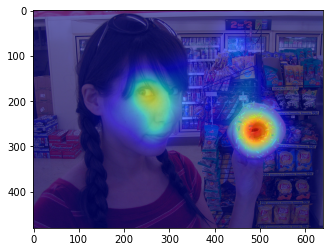

In [23]:
img = '/srv/chenshi/data/salicon/images/val/COCO_val2014_000000139856.jpg'
img = cv2.imread(img)
sal_map = '/srv/chenshi/data/salicon/sal/val/COCO_val2014_000000139856.jpg'
sal_map = cv2.imread(sal_map)[:,:,0].astype('float')
sal_map /= sal_map.max()
vis_map = overlay_heatmap(img, sal_map, plt.cm.jet)
plt.imshow(vis_map[:,:,::-1])

cv2.imwrite('/srv/chenshi/project/object_fractorization/prototype_dissection/final_result/image.png', img)
cv2.imwrite('/srv/chenshi/project/object_fractorization/prototype_dissection/final_result/attention.png', vis_map)

In [2]:
# select prototype visualization for figure
scene_graph = json.load(open('/srv/chenshi/data/GQA/scene_graph/train_sceneGraphs.json'))
selected_category = ['face', 'woman', 'eye', 'donut', 'staring', 'mouth', 'pink', 'glass', 
                     'hair', 'written', 'illumintated', 'shirt', 'light', 'box', 'goggles', 'having meeting', 'jersey', 'bag', 'glasses', 'bread']

save_data = dict()
for cur in selected_category:
    save_data[cur] = dict()
for img_id in scene_graph:
    for obj in scene_graph[img_id]['objects']:
        obj_name = scene_graph[img_id]['objects'][obj]['name']
        if obj_name in save_data and len(save_data[obj_name])<30:
            save_data[obj_name][img_id] = 1
            break
        else:
            for attr in scene_graph[img_id]['objects'][obj]['attributes']:
                if attr in save_data and len(save_data[attr])<30:
                    save_data[attr][img_id] = 1
            break

In [7]:
save_dir = '/srv/chenshi/project/object_fractorization/prototype_dissection/final_result/prototype'
img_dir  = '/srv/chenshi/data/GQA/images/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

for cat in save_data:
    if not os.path.exists(os.path.join(save_dir, cat)):
        os.mkdir(os.path.join(save_dir, cat))
    for img_id in save_data[cat]:
        shutil.copy(os.path.join(img_dir, img_id+'.jpg'), os.path.join(save_dir, cat, img_id+'.jpg'))

In [4]:
# visualize the interaction map
img_dir  = '/srv/chenshi/data/salicon/images/val/'
sal_dir = '/srv/chenshi/data/salicon/sal/val/'
save_dir = './interaction_vis/'
image_pool = glob(os.path.join('test/', '*'))
for img_folder in image_pool:
    img_name = os.path.basename(img_folder)
    cur_img = cv2.imread(os.path.join(img_dir, img_name+'.jpg'))
    shutil.copy(os.path.join(img_dir, img_name+'.jpg'), os.path.join(save_dir, img_name, 'image.jpg'))
    sal_map = cv2.imread(os.path.join(sal_dir, img_name+'.jpg'))[:,:,0].astype('float')
    sal_map /= sal_map.max()
    sal_map = overlay_heatmap(cur_img, sal_map, plt.cm.jet)
    cv2.imwrite(os.path.join(save_dir, img_name, 'saliency.jpg'), sal_map)
    
    sal_list = [os.path.basename(cur) for cur in glob(os.path.join(img_folder, '*'))]
    if not os.path.exists(os.path.join(save_dir, img_name)):
        os.mkdir(os.path.join(save_dir, img_name))
    for sal_map_name in sal_list:
        sal_map = cv2.imread(os.path.join(img_folder, sal_map_name))[:,:,0].astype('float')
#         sal_map = cv2.resize(sal_map, (640, 480))
        sal_map /= sal_map.max()
        y, x = sal_map_name[:-4].split('_')
        y, x = int(y)-60, int(x)
        vis_map = overlay_heatmap(cur_img, sal_map, plt.cm.jet)
#         cv2.circle(vis_map, (x, y), 30, (255, 0, 255), 3)
        cv2.imwrite(os.path.join(save_dir, img_name, sal_map_name), vis_map)
    
    


In [7]:
os.path.join(save_dir, img_name+'.jpg')

'./interaction_vis/COCO_val2014_000000143516.jpg'